Found 4486 images belonging to 2 classes.
Found 1122 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 64)        18496     
                                      

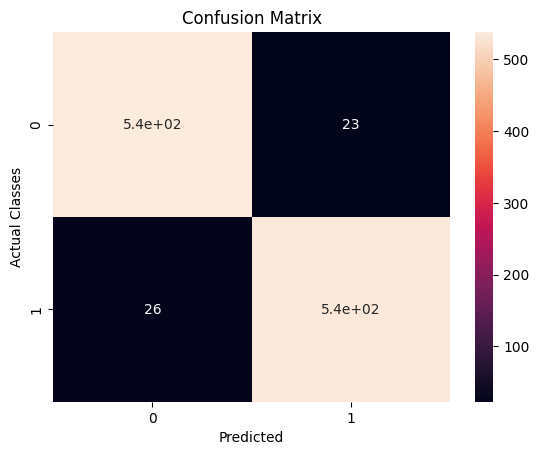

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2

# Update image size to 128x128
w, h = 256, 256
batch_size = 5

train_data_gen = ImageDataGenerator(rescale = 1.0/255)
test_data_gen = ImageDataGenerator(rescale = 1.0/255)

train_Dataset = train_data_gen.flow_from_directory(
    "../images/car/preprocessed_256x/train",
    target_size = (w, h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

test_Dataset = test_data_gen.flow_from_directory(
    "../images/car/preprocessed_256x/test",
    target_size = (w, h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False
)

# Update model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(w, h, 3), name='conv2d_1'))
model.add(layers.MaxPooling2D((2, 2), name='max_pooling2d_1'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_2'))
model.add(layers.MaxPooling2D((2, 2), name='max_pooling2d_2'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_3'))
model.add(layers.MaxPooling2D((2, 2), name='max_pooling2d_3'))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(128, activation='relu', name='dense_1'))
model.add(layers.Dropout(0.5, name='dropout_1'))
model.add(layers.Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

weight_path = './weights/'
model_checkpoint = ModelCheckpoint(
    filepath = weight_path,
    save_best_only = True,
    save_weights_only = True,
    mode = 'max',
    monitor = 'val_accuracy'
)
history = model.fit(train_Dataset, 
                    epochs=2, 
                    validation_data=test_Dataset,
                    callbacks=[model_checkpoint]
                   )

# Load best weights and make predictions
model.load_weights(weight_path)
predictions = model.predict(test_Dataset)
binary_predictions = (predictions > 0.5).astype(int)

# Generate confusion matrix and classification report
true_labels = test_Dataset.classes
sns.heatmap(confusion_matrix(true_labels, binary_predictions), annot=True)
print(classification_report(true_labels, binary_predictions))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

In [2]:
train_Dataset.class_indices

{'fake': 0, 'real': 1}

In [3]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Erstellen eines Modells, welches die Aktivierung der gewählten Conv-Schicht 
    # und die Ausgabe des Modells abbildet.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Berechnung des Gradienten der am höchsten vorhergesagten Klasse für das Eingabebild
    # in Bezug auf die Aktivierungen der letzten Conv-Schicht
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Dies ist der Gradient des Ausgabeneurons
    # in Bezug auf die Ausgabefeaturemap der Conv-Schicht
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Dies ist ein Vektor, wobei jeder Eintrag die mittlere Intensität des Gradienten
    # über einem spezifischen Featuremap-Kanal darstellt
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiplikation jedes Kanals in der Featuremap
    # mit dem Durchschnittswert des Gradienten für diesen Kanal, um zu erfahren,
    # wie wichtig dieser Kanal für die am höchsten vorhergesagte Klasse ist.
    # Dann summieren wir alle Kanäle, um die Klassenaktivierung für die Heatmap zu erhalten.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Die Heatmap normalisieren
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    # Eine Kanal-Dimension hinzufügen und die Größe anpassen
    heatmap = tf.expand_dims(heatmap, -1)  # Eine Kanal-Dimension hinzufügen
    heatmap = tf.image.resize(heatmap, (w, h))  # Heatmap in der Größe an das Eingabebild anpassen
    heatmap = tf.squeeze(heatmap)  # Die letzte Dimension entfernen, um sie wieder 2D zu machen

    return heatmap.numpy(), preds.numpy()

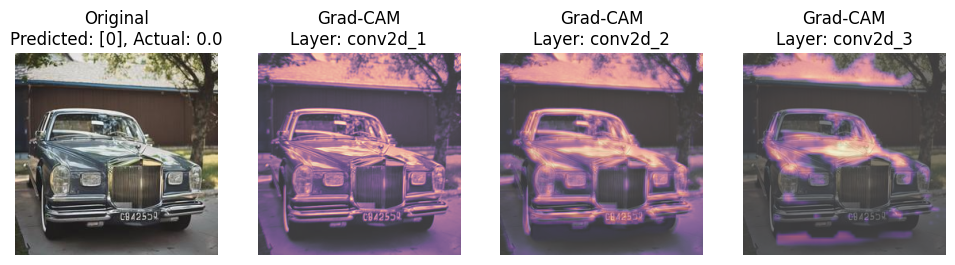

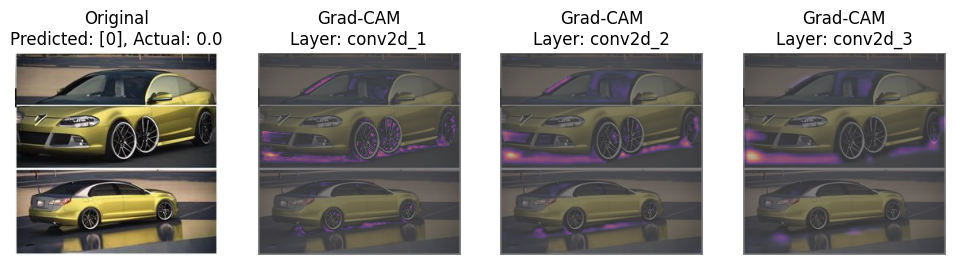

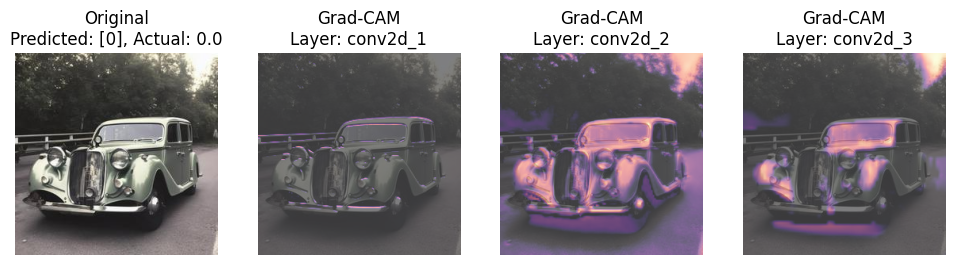

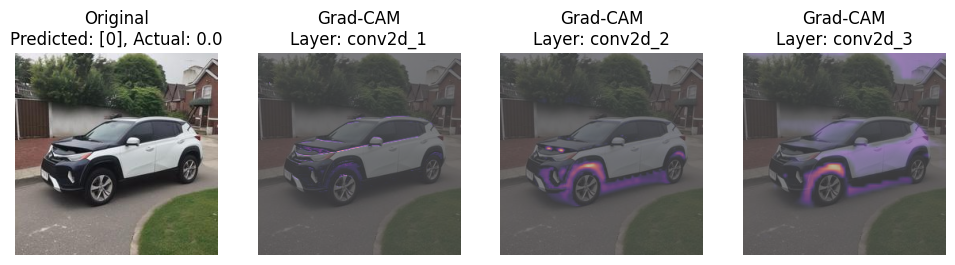

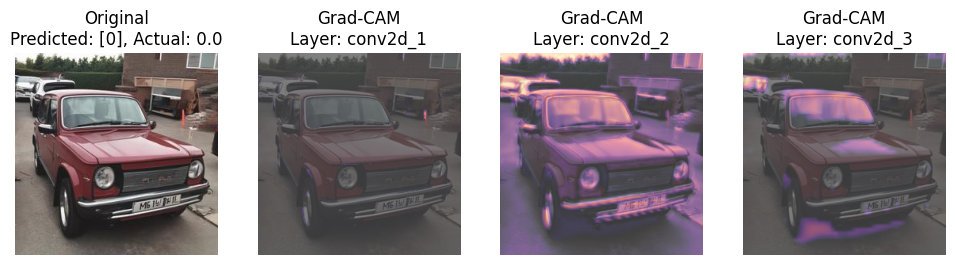

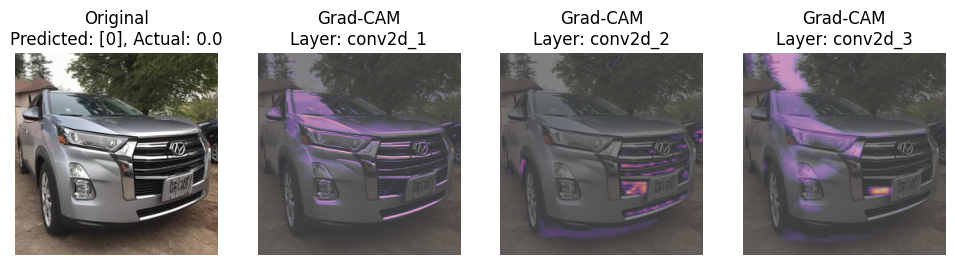

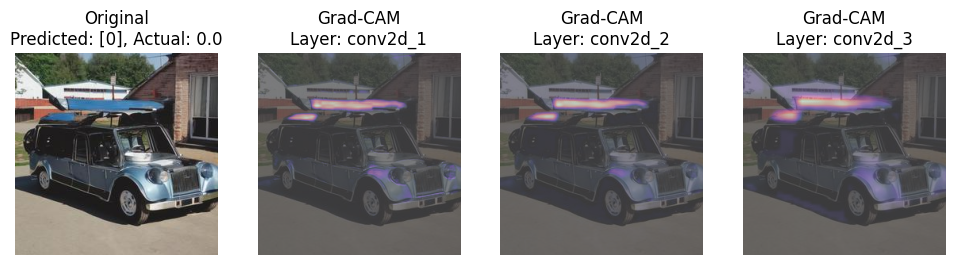

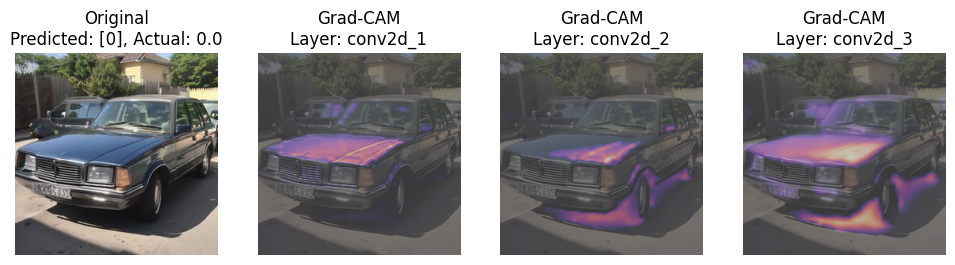

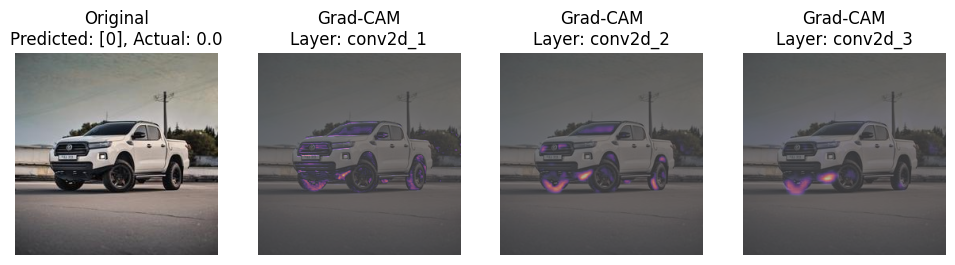

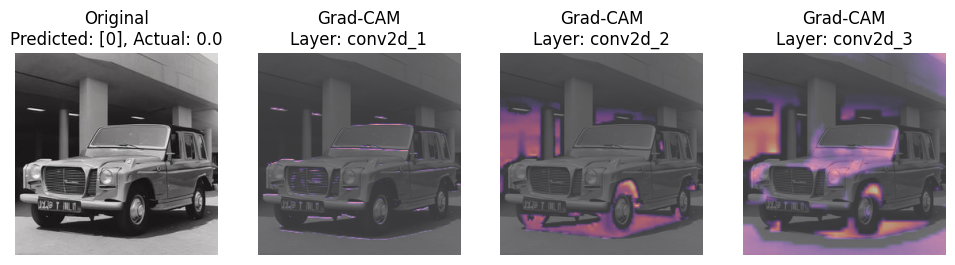

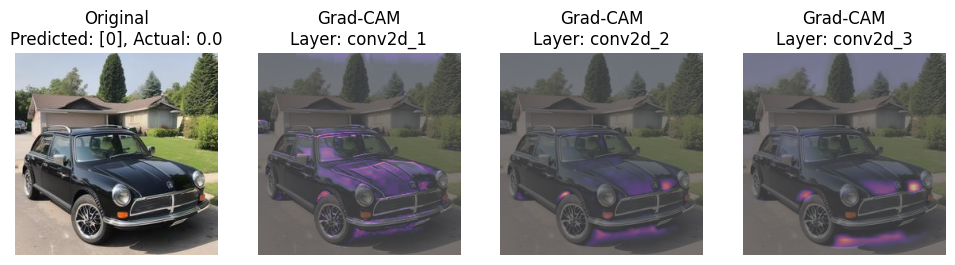

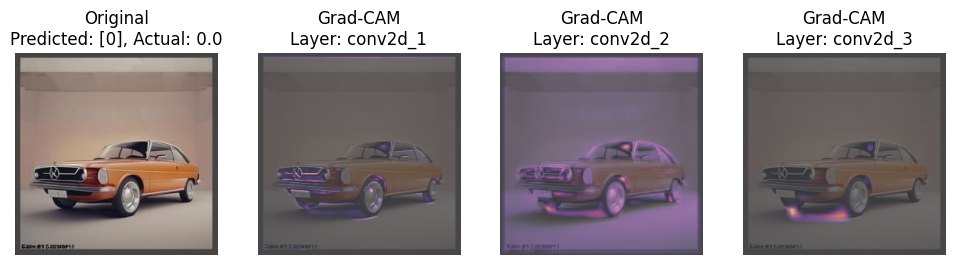

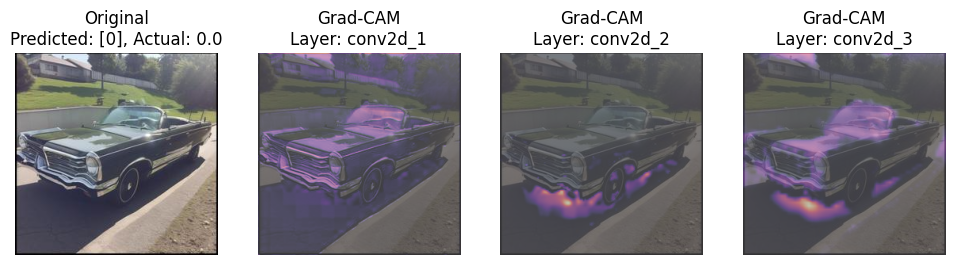

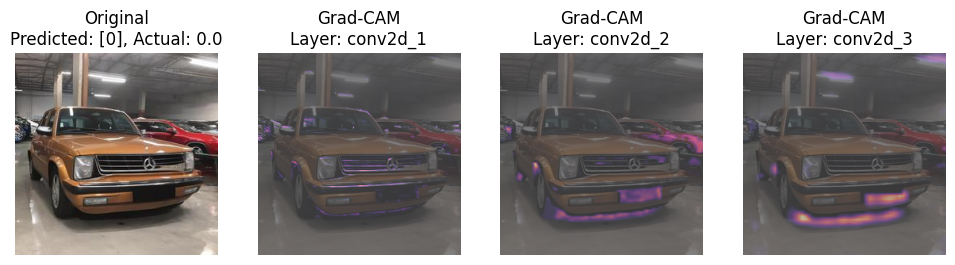

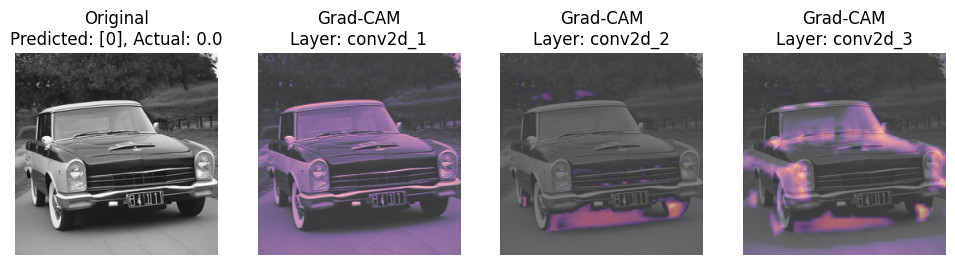

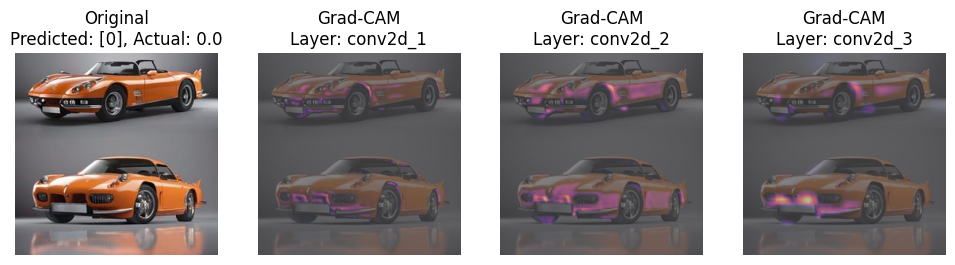

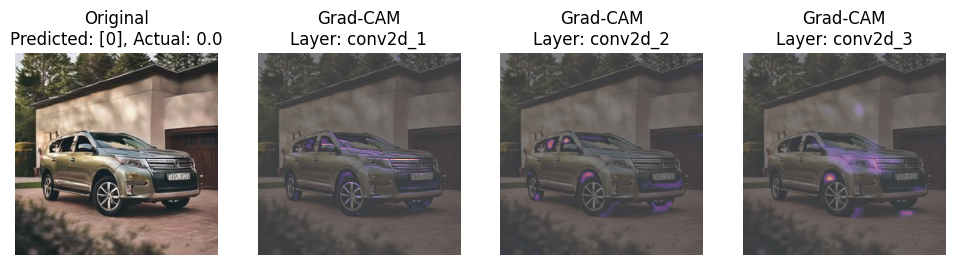

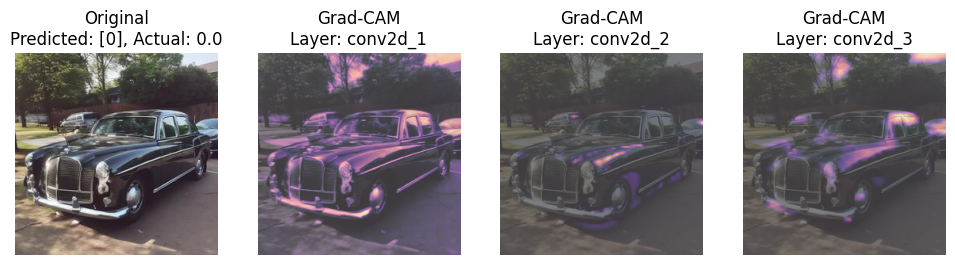

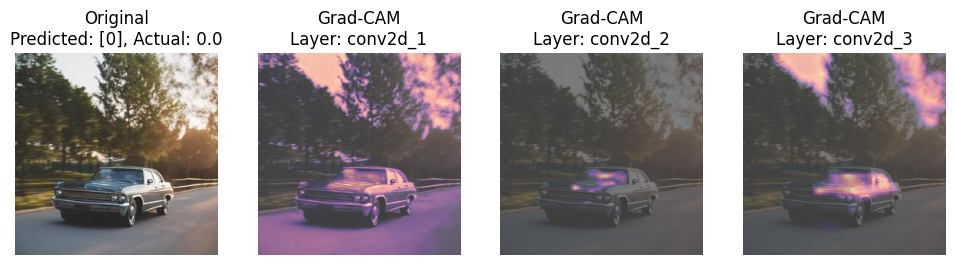

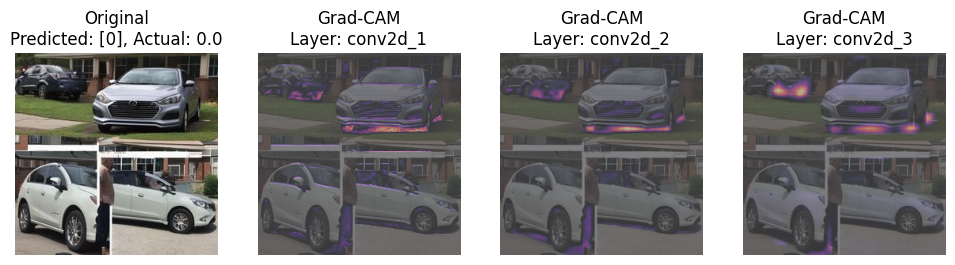

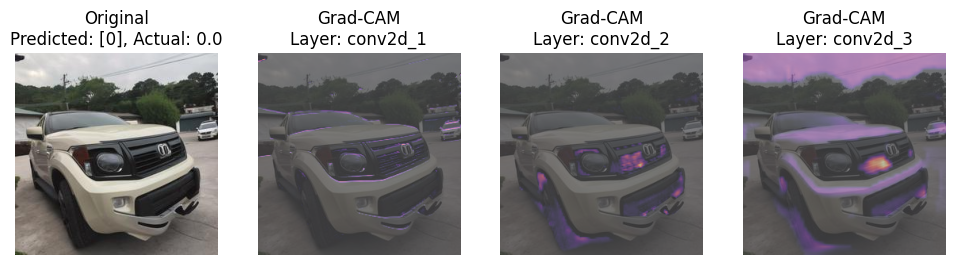

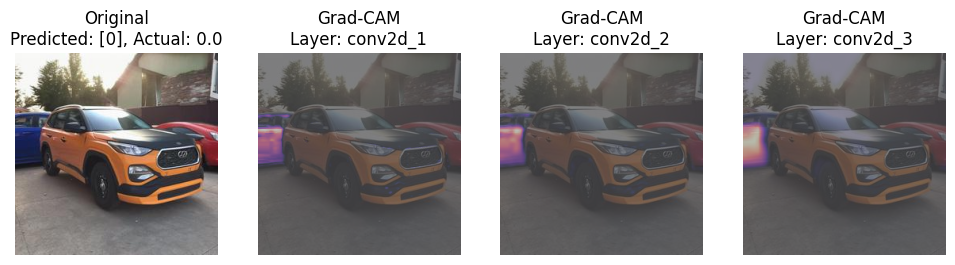

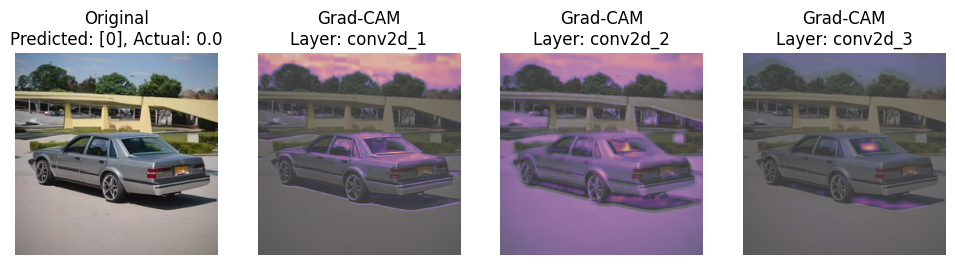

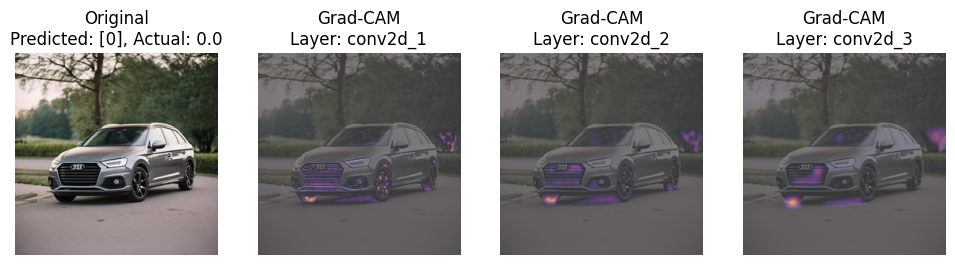

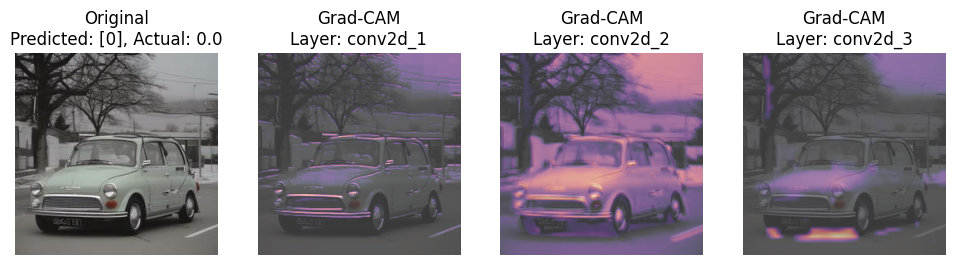

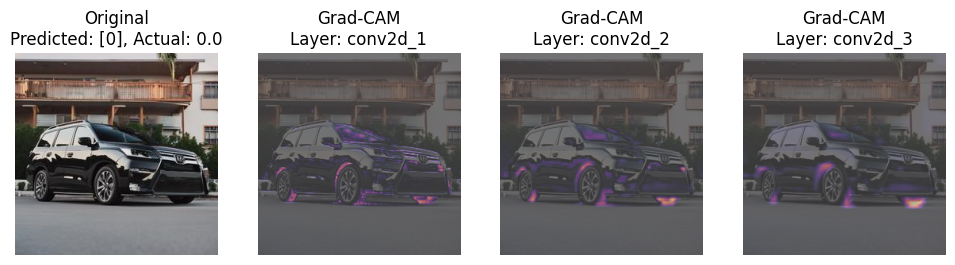

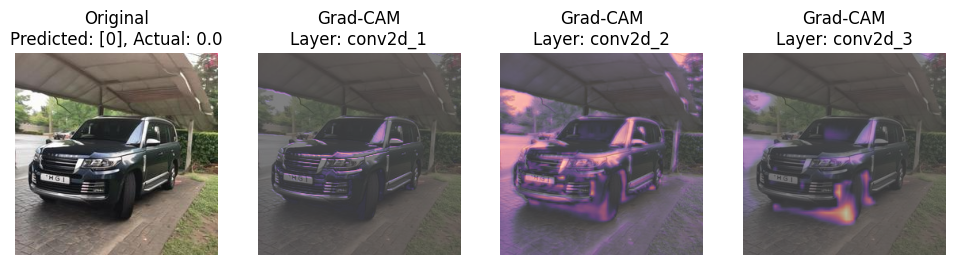

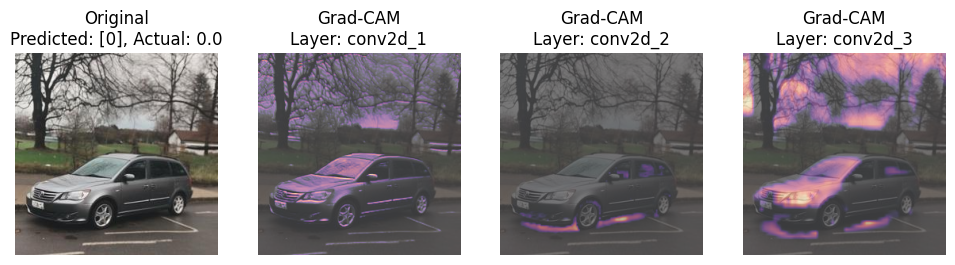

In [4]:
counter = 0

for images, labels in test_Dataset:
    
    for i in range(len(images)):
        if binary_predictions[i] == 0 and labels[i] == 0:
            counter = counter + 1
            image_processed = np.expand_dims(images[i], axis=0)

            plt.figure(figsize=(12, 6))  # Größere Figure, um alle Heatmaps sichtbar zu machen

            # Ursprüngliches Bild anzeigen
            plt.subplot(1, 4, 1)
            plt.imshow((images[i] * 255).astype("uint8"))
            plt.title(f'Original\nPredicted: {binary_predictions[i]}, Actual: {labels[i]}')
            plt.axis('off')

            # Heatmaps für jede Layer generieren und anzeigen
            layer_names = ['conv2d_1', 'conv2d_2', 'conv2d_3']
            for j, layer_name in enumerate(layer_names, start=2):  # Startet bei 2, da das Originalbild auf 1 ist
                heatmap, _ = make_gradcam_heatmap(image_processed, model, layer_name)
                
                plt.subplot(1, 4, j)
                plt.imshow((images[i] * 255).astype("uint8"), alpha=0.6)
                plt.imshow(heatmap, cmap='magma', alpha=0.5)  # Ensure heatmap is 2D
                plt.title(f'Grad-CAM\nLayer: {layer_name}')
                plt.axis('off')

            plt.show()

        if i >= 10:
            break
    if counter >= 25:
        break
        